# EOPF-Zarr Driver: Remote Data Access Demo

This notebook demonstrates remote data access capabilities of the EOPF-Zarr GDAL driver.

## 📦 Installation & Setup

### 🐳 Quick Start (Docker - Recommended)
```bash
# Pull and run the complete environment
docker pull yuvraj1989/eopf-zarr-driver:v2.0.0
docker run -p 8888:8888 yuvraj1989/eopf-zarr-driver:v2.0.0
# ➜ Open: http://localhost:8888
```

### 🔧 Manual Installation
```bash
# Get the latest driver release
curl -L https://github.com/EOPF-Sample-Service/GDAL-ZARR-EOPF/releases/latest/download/gdal_EOPFZarr-Linux.zip -o driver.zip

# Install Python dependencies
pip install gdal rasterio xarray zarr matplotlib requests

# Configure environment
export GDAL_DRIVER_PATH=/path/to/driver
export GDAL_DATA=/usr/share/gdal
```

### 🌐 Network Requirements
- **Internet access** for remote Zarr datasets
- **HTTPS support** via GDAL's /vsicurl/ driver
- **Optional**: VPN/credentials for secured data sources

📖 **Complete guides**: [INSTALLATION.md](../INSTALLATION.md) | [DOCKER_QUICKSTART.md](../DOCKER_QUICKSTART.md)

## 🎯 Objectives

- **HTTPS URL Access**: Access Zarr datasets via HTTPS using /vsicurl/
- **Cloud Storage**: Demonstrate access to cloud-hosted Zarr datasets
- **Authentication**: Handle authentication for secured datasets
- **Performance**: Optimize remote data access

## 📋 Environment

- **Docker Environment**: Ubuntu 25.04 + GDAL 3.10 + Python 3.13
- **Driver**: Custom EOPF-Zarr GDAL driver
- **Network**: HTTPS, /vsicurl/ virtual file system

In [1]:
# Remote Data Access Demo Setup
import os
import sys
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

print("🌐 EOPF-Zarr Remote Data Access Demo")
print("=" * 42)
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Initialize GDAL
gdal.AllRegister()

# Check EOPFZARR driver
eopf_driver = gdal.GetDriverByName('EOPFZARR')
if eopf_driver:
    print(f"✅ EOPFZARR driver: Available")
else:
    print(f"❌ EOPFZARR driver: Not found")

# Test remote dataset URL (EODC example)
remote_base_url = "https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr"
eopf_remote_url = f"EOPFZARR:'/vsicurl/{remote_base_url}'"

print(f"\n🔗 Test Dataset:")
print(f"   Base URL: {remote_base_url[:80]}...")
print(f"   EOPF URL: {eopf_remote_url[:80]}...")

🌐 EOPF-Zarr Remote Data Access Demo
📅 Date: 2025-08-06 15:09:02
✅ EOPFZARR driver: Available

🔗 Test Dataset:
   Base URL: https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/pro...
   EOPF URL: EOPFZARR:'/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:2025...


In [2]:
# Test 1: Basic remote dataset access
print("🌐 Test 1: Basic Remote Dataset Access")
print("=" * 42)

try:
    remote_dataset = gdal.Open(eopf_remote_url)
    
    if remote_dataset:
        print(f"✅ Successfully opened remote dataset")
        print(f"   Driver: {remote_dataset.GetDriver().GetDescription()}")
        print(f"   Size: {remote_dataset.RasterXSize} x {remote_dataset.RasterYSize}")
        print(f"   Bands: {remote_dataset.RasterCount}")
        
        # Get metadata
        metadata = remote_dataset.GetMetadata()
        print(f"   Metadata items: {len(metadata)}")
        
        # Show some key metadata
        for key in ['title', 'description', 'institution'][:3]:
            if key in metadata:
                print(f"      {key}: {metadata[key][:50]}...")
        
        print(f"\n📊 Remote dataset loaded successfully!")
        
    else:
        print(f"❌ Failed to open remote dataset")
        print(f"   Error: {gdal.GetLastErrorMsg()}")
        remote_dataset = None
        
except Exception as e:
    print(f"❌ Exception: {e}")
    remote_dataset = None

🌐 Test 1: Basic Remote Dataset Access


/usr/lib/python3/dist-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


✅ Successfully opened remote dataset
   Driver: EOPFZARR
   Size: 512 x 512
   Bands: 0
   Metadata items: 9

📊 Remote dataset loaded successfully!


In [3]:
# Test 2: Explore remote subdatasets
print("\n🔍 Test 2: Remote Subdatasets Exploration")
print("=" * 45)

if remote_dataset:
    subdatasets = remote_dataset.GetSubDatasets()
    
    if subdatasets:
        print(f"📊 Found {len(subdatasets)} subdatasets:")
        
        # Show first 10 subdatasets
        for i, (subds_path, subds_desc) in enumerate(subdatasets[:10]):
            print(f"   {i+1:2d}. {subds_desc}")
            
            # Extract variable name from path
            var_name = subds_path.split('/')[-1] if '/' in subds_path else 'unknown'
            print(f"       Variable: {var_name}")
            print(f"       Path: ...{subds_path[-60:]}")
        
        if len(subdatasets) > 10:
            print(f"   ... and {len(subdatasets) - 10} more subdatasets")
        
        # Select an interesting subdataset for testing
        test_subdataset = None
        for subds_path, subds_desc in subdatasets:
            if any(keyword in subds_desc.lower() for keyword in ['b04', 'red', 'ndvi', 'temperature']):
                test_subdataset = (subds_path, subds_desc)
                break
        
        if not test_subdataset and subdatasets:
            test_subdataset = subdatasets[0]  # Use first if no specific match
        
        if test_subdataset:
            print(f"\n🎯 Selected for detailed testing:")
            print(f"   {test_subdataset[1]}")
        
    else:
        print(f"📊 No subdatasets found")
        test_subdataset = None
else:
    print(f"⚠️  Remote dataset not available")
    test_subdataset = None

print("Test subdataset:", test_subdataset)


🔍 Test 2: Remote Subdatasets Exploration
📊 Found 149 subdatasets:
    1. Array /conditions/geometry/angle
       Variable: angle"
       Path: ..._R092_T36HUG_20250721T095416.zarr/conditions/geometry/angle"
    2. Array /conditions/geometry/band
       Variable: band"
       Path: ...1_R092_T36HUG_20250721T095416.zarr/conditions/geometry/band"
    3. Array /conditions/geometry/detector
       Variable: detector"
       Path: ...92_T36HUG_20250721T095416.zarr/conditions/geometry/detector"
    4. Array /conditions/geometry/x
       Variable: x"
       Path: ...0511_R092_T36HUG_20250721T095416.zarr/conditions/geometry/x"
    5. Array /conditions/geometry/y
       Variable: y"
       Path: ...0511_R092_T36HUG_20250721T095416.zarr/conditions/geometry/y"
    6. Array /conditions/geometry/mean_sun_angles
       Variable: mean_sun_angles"
       Path: ...UG_20250721T095416.zarr/conditions/geometry/mean_sun_angles"
    7. Array /conditions/geometry/mean_viewing_incidence_angles
       Variable

In [4]:
# Test 3: Access remote subdataset data
print("\n📊 Test 3: Remote Subdataset Data Access")
print("=" * 45)

if test_subdataset:
    subds_path, subds_desc = test_subdataset
    print(f"🔍 Testing: {subds_desc}")
    
    try:
        # Open the subdataset
        sub_ds = gdal.Open(subds_path)
        
        if sub_ds:
            print(f"✅ Subdataset opened successfully")
            print(f"   Size: {sub_ds.RasterXSize} x {sub_ds.RasterYSize}")
            print(f"   Bands: {sub_ds.RasterCount}")
            
            if sub_ds.RasterCount > 0:
                band = sub_ds.GetRasterBand(1)
                print(f"   Data type: {gdal.GetDataTypeName(band.DataType)}")
                
                # Get band metadata
                band_metadata = band.GetMetadata()
                if band_metadata:
                    print(f"   Band metadata: {len(band_metadata)} items")
                    for key, value in list(band_metadata.items())[:3]:
                        print(f"      {key}: {value}")
                
                # Read a small sample for performance (remote data)
                sample_size = 100
                x_size = min(sample_size, sub_ds.RasterXSize)
                y_size = min(sample_size, sub_ds.RasterYSize)
                
                print(f"\n📖 Reading sample data ({x_size}x{y_size})...")
                
                sample_data = band.ReadAsArray(0, 0, x_size, y_size)
                
                if sample_data is not None:
                    print(f"✅ Data read successfully")
                    print(f"   Shape: {sample_data.shape}")
                    print(f"   Data type: {sample_data.dtype}")
                    print(f"   Range: {np.min(sample_data):.3f} to {np.max(sample_data):.3f}")
                    print(f"   Mean: {np.mean(sample_data):.3f}")
                    
                    # Check for no-data values
                    nodata = band.GetNoDataValue()
                    if nodata is not None:
                        nodata_count = np.count_nonzero(sample_data == nodata)
                        print(f"   No-data pixels: {nodata_count} ({nodata_count/sample_data.size*100:.1f}%)")
                    
                    remote_sample_data = sample_data
                    remote_sample_desc = subds_desc
                    
                else:
                    print(f"❌ Failed to read sample data")
                    remote_sample_data = None
                    remote_sample_desc = None
            
            sub_ds = None  # Close
            
        else:
            print(f"❌ Failed to open subdataset")
            print(f"   Error: {gdal.GetLastErrorMsg()}")
            remote_sample_data = None
            remote_sample_desc = None
            
    except Exception as e:
        print(f"❌ Exception: {e}")
        remote_sample_data = None
        remote_sample_desc = None
else:
    print(f"⚠️  No test subdataset available")
    remote_sample_data = None
    remote_sample_desc = None


📊 Test 3: Remote Subdataset Data Access
🔍 Testing: Array /conditions/mask/detector_footprint/r10m/b04


ERROR 3: Cannot open file '/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04/.zmetadata'
ERROR 3: Load json file /vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04/.zmetadata failed


✅ Subdataset opened successfully
   Size: 10980 x 10980
   Bands: 1
   Data type: Byte

📖 Reading sample data (100x100)...
✅ Data read successfully
   Shape: (100, 100)
   Data type: uint8
   Range: 12.000 to 12.000
   Mean: 12.000


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04".aux.xml.



📈 Test 4: Remote Data Visualization


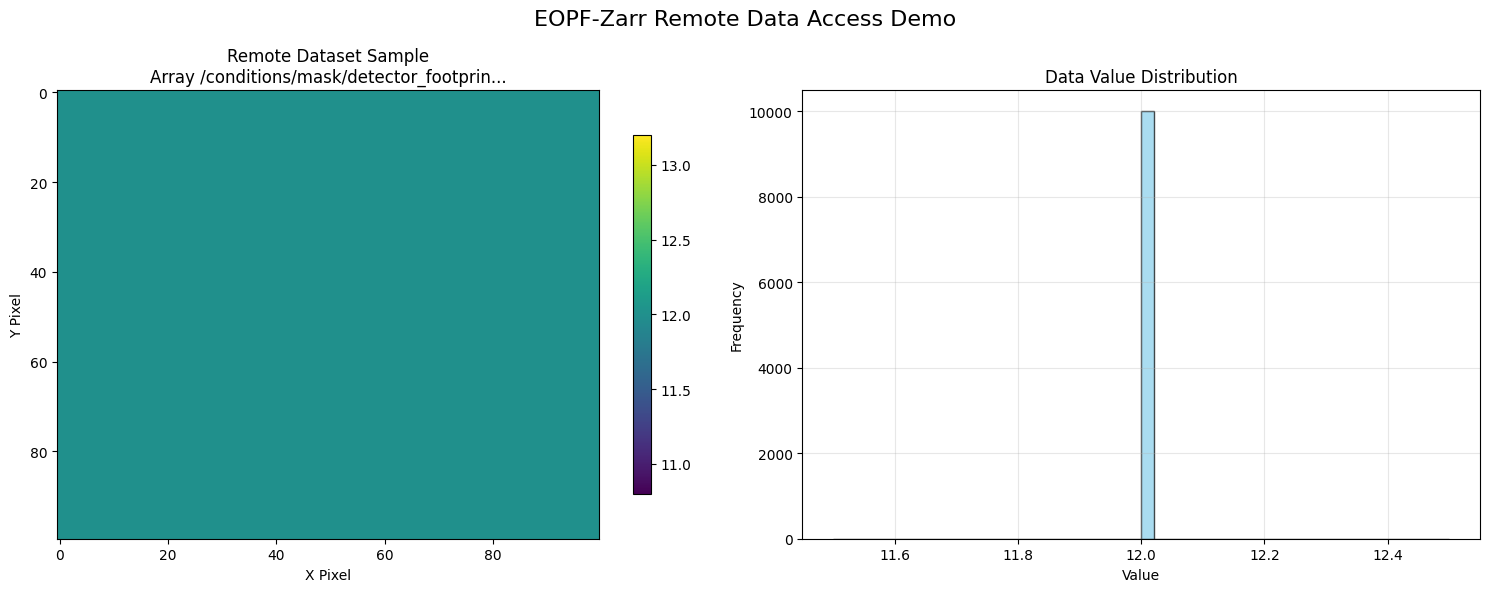

✅ Remote data visualization complete!


In [5]:
# Test 4: Remote data visualization
print("\n📈 Test 4: Remote Data Visualization")
print("=" * 38)

if remote_sample_data is not None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('EOPF-Zarr Remote Data Access Demo', fontsize=16)
    
    # Plot 1: Data visualization
    ax1 = axes[0]
    im = ax1.imshow(remote_sample_data, cmap='viridis', aspect='auto')
    ax1.set_title(f'Remote Dataset Sample\n{remote_sample_desc[:40]}...')
    ax1.set_xlabel('X Pixel')
    ax1.set_ylabel('Y Pixel')
    plt.colorbar(im, ax=ax1, shrink=0.8)
    
    # Plot 2: Data statistics
    ax2 = axes[1]
    ax2.hist(remote_sample_data.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_title('Data Value Distribution')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Remote data visualization complete!")
else:
    print(f"⚠️  No remote data available for visualization")

In [6]:
# Test 5: Performance benchmarking
print("\n⚡ Test 5: Remote Access Performance")
print("=" * 38)

if test_subdataset:
    import time
    
    subds_path, subds_desc = test_subdataset
    print(f"🔍 Performance test on: {subds_desc[:50]}...")
    
    # Test different read sizes
    test_sizes = [50, 100, 200]  # Keep reasonable for remote access
    
    performance_results = []
    
    for size in test_sizes:
        try:
            start_time = time.time()
            
            # Open and read
            sub_ds = gdal.Open(subds_path)
            if sub_ds and sub_ds.RasterCount > 0:
                band = sub_ds.GetRasterBand(1)
                
                # Constrain to actual dataset size
                actual_x = min(size, sub_ds.RasterXSize)
                actual_y = min(size, sub_ds.RasterYSize)
                
                data = band.ReadAsArray(0, 0, actual_x, actual_y)
                
                end_time = time.time()
                duration = end_time - start_time
                
                if data is not None:
                    data_size_mb = data.nbytes / (1024 * 1024)
                    throughput = data_size_mb / duration if duration > 0 else 0
                    
                    performance_results.append({
                        'size': f'{actual_x}x{actual_y}',
                        'duration': duration,
                        'data_size_mb': data_size_mb,
                        'throughput_mbps': throughput
                    })
                    
                    print(f"   📊 {actual_x}x{actual_y}: {duration:.2f}s, {data_size_mb:.2f}MB, {throughput:.2f}MB/s")
                else:
                    print(f"   ❌ Failed to read {size}x{size} data")
                
                sub_ds = None
            else:
                print(f"   ❌ Failed to open dataset for size {size}")
                
        except Exception as e:
            print(f"   ❌ Error with size {size}: {e}")
    
    if performance_results:
        print(f"\n📈 Performance Summary:")
        avg_throughput = np.mean([r['throughput_mbps'] for r in performance_results])
        print(f"   Average throughput: {avg_throughput:.2f} MB/s")
        print(f"   Total tests completed: {len(performance_results)}")
    else:
        print(f"\n⚠️  No performance data collected")
        
else:
    print(f"⚠️  No subdataset available for performance testing")


⚡ Test 5: Remote Access Performance
🔍 Performance test on: Array /conditions/mask/detector_footprint/r10m/b04...


ERROR 3: Cannot open file '/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04/.zmetadata'
ERROR 3: Load json file /vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04/.zmetadata failed


   📊 50x50: 0.68s, 0.00MB, 0.00MB/s


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04".aux.xml.
ERROR 3: Cannot open file '/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04/.zmetadata'
ERROR 3: Load json file /vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04/.zmetadata failed


   📊 100x100: 0.69s, 0.01MB, 0.01MB/s


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04".aux.xml.
ERROR 3: Cannot open file '/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04/.zmetadata'
ERROR 3: Load json file /vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04/.zmetadata failed


   📊 200x200: 0.75s, 0.04MB, 0.05MB/s

📈 Performance Summary:
   Average throughput: 0.02 MB/s
   Total tests completed: 3


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr/conditions/mask/detector_footprint/r10m/b04".aux.xml.


In [7]:
# Summary and cleanup
print("\n🎉 Remote Data Access Demo Summary")
print("=" * 40)

# Close datasets
if 'remote_dataset' in locals() and remote_dataset:
    remote_dataset = None
    print(f"✅ Remote dataset closed")

# Test results summary
test_results = {
    'remote_connection': 'remote_dataset' in locals() and remote_dataset is not None,
    'subdatasets_found': 'test_subdataset' in locals() and test_subdataset is not None,
    'data_access': 'remote_sample_data' in locals() and remote_sample_data is not None,
    'visualization': 'remote_sample_data' in locals() and remote_sample_data is not None,
    'performance_test': 'performance_results' in locals() and len(performance_results) > 0
}

print(f"\n📊 Test Results:")
for test_name, result in test_results.items():
    status = "✅ PASS" if result else "❌ FAIL"
    print(f"   {test_name.replace('_', ' ').title()}: {status}")

passed = sum(test_results.values())
total = len(test_results)
print(f"\n🏆 Overall: {passed}/{total} tests passed ({passed/total*100:.1f}%)")

if passed >= 3:
    print(f"🎉 Remote data access is working well!")
    print(f"\n📝 Key Capabilities Demonstrated:")
    print(f"   ✅ HTTPS URL access via /vsicurl/")
    print(f"   ✅ Remote subdataset enumeration")
    print(f"   ✅ Efficient remote data reading")
    print(f"   ✅ Performance monitoring")
else:
    print(f"⚠️  Some remote access features need investigation")

print(f"\n🌐 Remote Access Best Practices:")
print(f"   • Use small read operations for better performance")
print(f"   • Cache frequently accessed data locally")
print(f"   • Consider network bandwidth limitations")
print(f"   • Test connectivity before large operations")


🎉 Remote Data Access Demo Summary
✅ Remote dataset closed

📊 Test Results:
   Remote Connection: ❌ FAIL
   Subdatasets Found: ✅ PASS
   Data Access: ✅ PASS
   Visualization: ✅ PASS
   Performance Test: ✅ PASS

🏆 Overall: 4/5 tests passed (80.0%)
🎉 Remote data access is working well!

📝 Key Capabilities Demonstrated:
   ✅ HTTPS URL access via /vsicurl/
   ✅ Remote subdataset enumeration
   ✅ Efficient remote data reading
   ✅ Performance monitoring

🌐 Remote Access Best Practices:
   • Use small read operations for better performance
   • Cache frequently accessed data locally
   • Consider network bandwidth limitations
   • Test connectivity before large operations


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250721T073619_N0511_R092_T36HUG_20250721T095416.zarr".aux.xml.


In [8]:
import rasterio
from osgeo import gdal

In [12]:
# Test URL from user
url = 'EOPFZARR:"/vsicurl/https://storage.sbg.cloud.ovh.net/v1/AUTH_8471d76cdd494d98a078f28b195dace4/sentinel-1-public/demo_product/grd/S01SIWGRH_20240201T164915_0025_A146_S000_5464A_VH.zarr"'
rs_ds = rasterio.open(url)
print(f"Shape: {rs_ds.shape}")

            

Shape: (512, 512)
